# Random Forest Gene Signature Deconvolution
Andrew E. Davidson  
aedavids@ucsc.edu  
7/2/24

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0

ref: extraCellularRNA/deconvolutionAnalysis/jupyterNotebooks/randomForestGeneSignatureDeconvolutionPOC.ipynb


**Abstract**  
randomForestGeneSignatureDeconvolutionPOC trained a random forest model on our GTEx_TCGA training data set using RepeatedStratifiedKFold() and cross_validate(). 

model trained on GTEx_TCGA training data set has perfect TP! See confusion matrix plot

model saved to /private/groups/kimlab/aedavids/deconvolution/randomForestGeneSignatureDeconvolution.out

In [30]:
# Elife is missing some feature. Train using a sub set
# see intraExtraRNA_POC/jupyterNotebooks/elife/randomForestGTEx_TCGAGeneSignature.ipynb
trainElifeFeatures = True

In [2]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display
import joblib
import logging
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
# display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.metrics import confusion_matrix
from sklearn.ensemble      import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# from sklearn.metrics         import recall_score
# from sklearn.metrics         import roc_auc_score
# from sklearn.metrics         import make_scorer

import sys

/data/tmp/ipykernel_1291038/1961124458.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
meaningOfLife = 42

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

#outDir = f'{notebookDir}/{notebookName}.out'
outDir = f'/private/groups/kimlab/aedavids/deconvolution/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

#loglevel = "INFO"
loglevel = "WARN"
# logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    
logger = logging.getLogger(notebookName)

outDir:
/private/groups/kimlab/aedavids/deconvolution/randomForestGeneSignatureDeconvolution.out

modelOutDir ;
/private/groups/kimlab/aedavids/deconvolution/randomForestGeneSignatureDeconvolution.out/model

imgOut :
/private/groups/kimlab/aedavids/deconvolution/randomForestGeneSignatureDeconvolution.out/img


In [4]:
# setting the python path allows us to run python scripts from using
# the CLI. 
PYTHONPATH = os.environ['PYTHONPATH']
print("ORIG_PYTHONPATH: {}\n".format(PYTHONPATH))

gitRepoRoot = !git rev-parse --show-toplevel
gitRepoRoot = gitRepoRoot[0]

#
# add deconvolutionAnalysis modules
#
deconvolutionModules = f'{gitRepoRoot}/deconvolutionAnalysis/python'
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = PYTHONPATH + f':{deconvolutionModules}'
#print("PYTHONPATH: {}\n".format(PYTHONPATH))

sys.path.append( str(deconvolutionModules) )
#print("\nsys.path:\n{}\n".format(sys.path))

#
# add intraExtraRNA_POC modules
#
intraExtraRNA_POCModules = f'{gitRepoRoot}/intraExtraRNA_POC/python/src'
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
#print("PYTHONPATH: {}\n".format(PYTHONPATH))

sys.path.append( str(intraExtraRNA_POCModules) )
#print("\nsys.path:\n{}\n".format(sys.path))

ORIG_PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src

deconvolutionModules: /private/home/aedavids/extraCellularRNA/deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/python/src



In [5]:
# local imports
#debug multi class from models.randomForestHyperparmeterSearch import createScoringMetricsDict
# from models.randomForestHyperparmeterSearch import evaluateModel
from analysis.utilities import saveList, loadList
from confusion_matrix.cf_matrix import make_confusion_matrix
from models.mlUtilities import saveLabelEncoder
from pipeline.dataFactory.utilities import urlify

In [6]:
runName = "best10CuratedDegree1_ce467ff"
weird = "best10CuratedDegree1"
rootDir = "/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category"
runOutDir = f'{rootDir}/{runName}/training/{weird}.sh.out'
ciberSortInput = "GTEx_TCGA-design-tilda_gender_category-padj-0001-lfc-20-n-10/ciberSortInput"

# Create expected values
i.e. one hot encoded labels

In [7]:
expectedFractionsPath = f'{runOutDir}/{ciberSortInput}/expectedFractions.txt'
! ls $expectedFractionsPath

/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best10CuratedDegree1_ce467ff/training/best10CuratedDegree1.sh.out/GTEx_TCGA-design-tilda_gender_category-padj-0001-lfc-20-n-10/ciberSortInput/expectedFractions.txt


In [8]:
%%time
expectedFractionsDF = pd.read_csv(expectedFractionsPath, sep="\t",  index_col="sample_id")
print(f'expectedFractionsDF.shape : {expectedFractionsDF.shape}')
expectedFractionsDF.iloc[0:5, 0:9]

expectedFractionsDF.shape : (15801, 88)
CPU times: user 194 ms, sys: 39.8 ms, total: 234 ms
Wall time: 472 ms


,participant_id,category,gender,age,dataSet,ACC,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland
sample_id,,,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F,Adipose_Subcutaneous,Female,66.0,GTEx,0.0,1.0,0.0,0.0
GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F,Artery_Tibial,Female,66.0,GTEx,0.0,0.0,0.0,0.0
GTEX-1117F-0726-SM-5GIEN,GTEX-1117F,Heart_Atrial_Appendage,Female,66.0,GTEx,0.0,0.0,0.0,0.0
GTEX-1117F-2826-SM-5GZXL,GTEX-1117F,Breast_Mammary_Tissue,Female,66.0,GTEx,0.0,0.0,0.0,0.0
GTEX-1117F-3226-SM-5N9CT,GTEX-1117F,Brain_Cortex,Female,66.0,GTEx,0.0,0.0,0.0,0.0


In [9]:
YSeries = expectedFractionsDF.loc[:,'category']
print(f'YSeries.shape : {YSeries.shape}')
YSeries[0:5]

YSeries.shape : (15801,)


sample_id
GTEX-1117F-0226-SM-5GZZ7      Adipose_Subcutaneous
GTEX-1117F-0526-SM-5EGHJ             Artery_Tibial
GTEX-1117F-0726-SM-5GIEN    Heart_Atrial_Appendage
GTEX-1117F-2826-SM-5GZXL     Breast_Mammary_Tissue
GTEX-1117F-3226-SM-5N9CT              Brain_Cortex
Name: category, dtype: object

In [10]:
labelEncoder = LabelEncoder()
labelEncoder.fit(YSeries)
labelList = list( labelEncoder.classes_ )
print(f'num classes : {len(labelList)}' )
labelList[0:5]

num classes : 83


['ACC',
 'Adipose_Subcutaneous',
 'Adipose_Visceral_Omentum',
 'Adrenal_Gland',
 'Artery_Aorta']

# Load normalized counts

In [11]:
mixturePath = f'{runOutDir}/{ciberSortInput}/mixture.txt'
! ls $mixturePath

/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best10CuratedDegree1_ce467ff/training/best10CuratedDegree1.sh.out/GTEx_TCGA-design-tilda_gender_category-padj-0001-lfc-20-n-10/ciberSortInput/mixture.txt


In [12]:
%%time
mixtureDF = pd.read_csv(mixturePath, sep="\t", index_col="sampleTitle")
print(f'mixtureDF.shape : {mixtureDF.shape}')
mixtureDF.iloc[0:5, 0:5]

mixtureDF.shape : (716, 15801)
CPU times: user 6.06 s, sys: 405 ms, total: 6.46 s
Wall time: 7.83 s


,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-3226-SM-5N9CT
sampleTitle,,,,,
(GGTG)n,19.001808,26.644422,12.776613,72.892107,26.525577
(GT)n,833.601046,664.744176,401.398583,918.272979,427.061784
(TA)n,29.741960,14.346997,13.841330,25.135209,5.968255
(TCCAC)n,0.000000,1.366381,0.000000,0.837840,0.000000
(TCTATG)n,0.000000,0.000000,0.000000,0.000000,0.663139


In [13]:
XDF = mixtureDF.transpose()
print(f'XDF.shape : {XDF.shape}')
display( XDF.iloc[0:5, 0:5].index )
XDF.iloc[0:5, 0:5]


XDF.shape : (15801, 716)


Index(['GTEX-1117F-0226-SM-5GZZ7', 'GTEX-1117F-0526-SM-5EGHJ',
       'GTEX-1117F-0726-SM-5GIEN', 'GTEX-1117F-2826-SM-5GZXL',
       'GTEX-1117F-3226-SM-5N9CT'],
      dtype='object')

sampleTitle,(GGTG)n,(GT)n,(TA)n,(TCCAC)n,(TCTATG)n
GTEX-1117F-0226-SM-5GZZ7,19.001808,833.601046,29.741960,0.000000,0.000000
GTEX-1117F-0526-SM-5EGHJ,26.644422,664.744176,14.346997,1.366381,0.000000
GTEX-1117F-0726-SM-5GIEN,12.776613,401.398583,13.841330,0.000000,0.000000
GTEX-1117F-2826-SM-5GZXL,72.892107,918.272979,25.135209,0.837840,0.000000
GTEX-1117F-3226-SM-5N9CT,26.525577,427.061784,5.968255,0.000000,0.663139


In [14]:
# Add the category column to counts
labeledXDF = pd.merge(XDF, expectedFractionsDF.loc[:, ['category']], how='inner',left_index=True, right_index=True) # left_on="sampleTitle", right_on="sample_id"
print(labeledXDF.shape)
display(labeledXDF.iloc[0:5, -5:])

(15801, 717)


,ZNRF1,ZRANB1,ZSWIM4,ZYG11B,category
GTEX-1117F-0226-SM-5GZZ7,712.154709,1738.252329,247.849667,785.683443,Adipose_Subcutaneous
GTEX-1117F-0526-SM-5EGHJ,651.763560,1028.201423,151.668250,678.407982,Artery_Tibial
GTEX-1117F-0726-SM-5GIEN,234.237900,421.628220,98.486390,466.346365,Heart_Atrial_Appendage
GTEX-1117F-2826-SM-5GZXL,918.272979,967.705557,318.379317,811.029419,Breast_Mammary_Tissue
GTEX-1117F-3226-SM-5N9CT,590.857220,759.294632,94.828937,578.257571,Brain_Cortex


In [49]:
if trainElifeFeatures :
    missingIdsPath = f'{modelOutDir}/missingElifeFeatures.csv' 
    missingHugoIdSeries = pd.read_csv( missingIdsPath )
    mList = missingHugoIdSeries.values.reshape(-1)
    logger.warning(f'model trained for elife data set. following genes where dropped : {mList}')

    # select columns not in the missing list
    selectCols = ~ XDF.columns.isin(mList) 
    print(f'orginal XDF.shape : {XDF.shape}')
    XDF = XDF.loc[:, selectCols]
    print(f'XDF.shape : {tmpDF.shape}')


2024-07-22 11:52:10,807 WARNING randomForestGeneSignatureDeconvolution <module>() line:5] [model trained for elife data set. following genes where dropped : ['AC092140.2' 'CTAGE8' 'AC119396.1' 'AC118281.1']]


orginal XDF.shape : (15801, 716)
XDF.shape : (15801, 712)


In [50]:
# Convert to Random Forest Format

In [51]:
# do not train with numpy arrays. Use DataFrame
# if you train with data frames, the saved model will have the feature_names_in_ attribute i

# XNP = XDF.values
# print(f'XNP.shape : {XNP.shape}')
# print(type(XNP))
# print(XNP[0:5, 0:5])

In [52]:
yNP = labelEncoder.transform( labeledXDF.loc[:, 'category'] ) # .values
# yNP = labelEncoder.transform( ['Adipose_Subcutaneous', 'Artery_Tibial', 'Heart_Atrial_Appendage',
#                                'UVM', 'UVM', 'UVM'] )
print(f'yNP.shape : {yNP.shape}')
print(f'yNP[0:5, :] \n{yNP[0:5]}')
print(f'\nlabelEncoder.inverse_transform( yNP[0:5] ) :\n {labelEncoder.inverse_transform( yNP[0:5] )}')

yNP.shape : (15801,)
yNP[0:5, :] 
[ 1  6 39 23 15]

labelEncoder.inverse_transform( yNP[0:5] ) :
 ['Adipose_Subcutaneous' 'Artery_Tibial' 'Heart_Atrial_Appendage'
 'Breast_Mammary_Tissue' 'Brain_Cortex']


In [53]:
labeledXDF.loc[:, 'category'].values

array(['Adipose_Subcutaneous', 'Artery_Tibial', 'Heart_Atrial_Appendage',
       ..., 'UVM', 'UVM', 'UVM'], dtype=object)

# Train Random Forest

In [54]:
%%time
rfModel = RandomForestClassifier(random_state=meaningOfLife, )
#rfModel.fit(XNP, yNP)
rfModel.fit(XDF, yNP)

CPU times: user 2min 34s, sys: 499 ms, total: 2min 34s
Wall time: 3min 14s


RandomForestClassifier(random_state=42)

In [55]:
%%time
# yHatNP = rfModel.predict( XNP )
yHatNP = rfModel.predict( XDF )
print(f'yHatNP.shape : {yHatNP.shape}')
print(f'yHatNP[0:5], {yHatNP[0:5]}')

yHatNP.shape : (15801,)
yHatNP[0:5], [ 1  6 39 23 15]
CPU times: user 1.09 s, sys: 91.4 ms, total: 1.18 s
Wall time: 1.5 s


## Save trained model

In [56]:
# save the model
if trainElifeFeatures :
    suffix = "_elife"
else:
    suffix = ""
    
rfPath = f'{modelOutDir}/{runName}{suffix}.joblib' 
joblib.dump(rfModel, rfPath)
print(f'\nrandom forest model saved to :\n {rfPath}')

# save label encoder
labelEncoderPath = f'{modelOutDir}/{runName}{suffix}.labelEncoder.txt' 
saveLabelEncoder(labelEncoderPath,labelEncoder)
print(f'\nlabelEncoder saved to :\n {labelEncoderPath}')


random forest model saved to :
 /private/groups/kimlab/aedavids/deconvolution/randomForestGeneSignatureDeconvolution.out/model/best10CuratedDegree1_ce467ff_elife.joblib

labelEncoder saved to :
 /private/groups/kimlab/aedavids/deconvolution/randomForestGeneSignatureDeconvolution.out/model/best10CuratedDegree1_ce467ff_elife.labelEncoder.txt


In [57]:
# save columns
# the model should have an attribute n_features_in_ if it was trained on a data frame
# just be safe save the ordered list of columns 

featurePath = f'{modelOutDir}/{runName}{suffix}.orderedFeatures.txt'
saveList(featurePath, list( XDF.columns) )
print(f'\featurePath saved to :\n {featurePath}')

eaturePath saved to :
 /private/groups/kimlab/aedavids/deconvolution/randomForestGeneSignatureDeconvolution.out/model/best10CuratedDegree1_ce467ff_elife.orderedFeatures.txt


## Evaluate Model

## extraCellularRNA/terra/jupyterNotebooks/cibersort/fractionsAsMulticlassClassification.ipynb
copied ploting code from advancement. make_confusion_matrix() did not work well when we have a large # of classes

**<span style="color:red;background-color:yellow">refactor notebooks</span>**  

- deconvolutionAnalysis/jupyterNotebooks/randomForestGeneSignatureDeconvolution.ipynb
- intraExtraRNA_POC/jupyterNotebooks/elife/randomForestGTEx_TCGAGeneSignature.ipynb

In [58]:
import bme263DataVis.utilities as utl
import seaborn as sns

def plotConfusionMatrix(confusionData, labels, annotations, imgOutDir, title, pageWidthInInches, 
                        pageHeightInInches, displayCounts=False):
    '''
    arguments
        confusionData, labels, 
        
        annotations
            string values to display in heat map cells, must have same shape as confusionData
        
        imgOutDir, title, pageWidthInInches, pageHeightInInches
        
        displayCounts:
            boolean: default = False
            if true fmt is set to '.0f', and annotations are not displayed
    '''
    
    plotUtils =  utl.MatPlotLibUtilities()
    fig = plt.figure( figsize=(pageWidthInInches, pageHeightInInches) )

    # correlation
    cbarPanelWidthInInches = 0.25 #0.5
    panelWidthInInches = pageWidthInInches - cbarPanelWidthInInches
    panelHeightInInches = pageHeightInInches 
    leftRelativeSize = 0
    bottomRelativeSize = 0
    panel = plotUtils.createPanel(fig, panelWidthInInches, panelHeightInInches, 
                                             leftRelativeSize, bottomRelativeSize)
    
    cbarPanelHeightInInches = panelHeightInInches - 2 #1
    cbarLeftRelativeSize = 0.99 #0.985 #0.975 # 0.95   # % of fig width
    cbarBottomRelativeSize = 0.08 #0.1 #0.125 #0.15 # 0.10 # % of fig height
    cbarPanel = plotUtils.createPanel(fig, cbarPanelWidthInInches, cbarPanelHeightInInches, 
                                             cbarLeftRelativeSize, cbarBottomRelativeSize)

    if (displayCounts):
        panel = sns.heatmap( confusionData 
                            , xticklabels = labels
                            , yticklabels = labels
                            , ax = panel
                            , cbar_ax = cbarPanel
                            , cmap = "Blues"
                            #, cmap="viridis"
                            , annot = True # display the numeric values in confusionData
                            #, fmt='.2%' # use if annot = True # default is '.2g'
                            , fmt=".0f" # use to display true positive counts
                            , square=True
                            , linecolor = "black" # default is "white"
                            , linewidths = 1.0
                   )
    else:
        panel = sns.heatmap( confusionData 
                        , xticklabels = labels
                        , yticklabels = labels
                        , ax = panel
                        , cbar_ax = cbarPanel
                        , cmap = "Blues"
                        #, cmap="viridis"                            
                        , annot = annotations
                        , fmt='' # required if our annotations are strings
                        , square=True
                        , linecolor = "black" # default is "white"
                        , linewidths = 1.0

               )        

    panel.set_title(title)
    panel.set_ylabel('Actual')
    panel.set_xlabel('Predicted')

    # https://drawingfromdata.com/seaborn/matplotlib/visualization/rotate-axis-labels-matplotlib-seaborn.html
    panel.set_xticklabels(panel.get_xticklabels(), rotation=45, horizontalalignment='right')

    # imgFile = imgOutDir.joinpath( urlify(title) + ".png" )
    imgFile = f'{imgOutDir}/{urlify(title) + ".png"}'
    print(f"save: {imgFile}")
    plt.savefig( imgFile , bbox_inches='tight', dpi=300,  facecolor="white", transparent=True)

In [59]:
def plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start, end, displayCounts=False):
    pageWidthInInches  = 8
    pageHeightInInches = 8
    
    if displayCounts:
        confusionData = cfMatrix
        annot = None
    else :
        confusionData = calculateRowPercentages( cfMatrix )
        annotations = createHeatMapAnnotations( confusionData )
        annot = annotations[start:end, start:end]

    cfMatrixL = confusionData[start:end, start:end] # confusion_matrix is TP, FP counts we want percentages 
    labelsL = labels[start:end]
    plotConfusionMatrix(cfMatrixL, labelsL, annot, imgOutDir, title, pageWidthInInches, 
                        pageHeightInInches, displayCounts)

In [60]:
def calculateRowPercentages(cm):
    '''
    divides each value in a row by the row totoal
    
    arguments:
        cm: a confusion matrix
        
    returns
        a numpy array with same shape as cm 
    '''
    byRows = 1
    rowMarginEquals1 = np.sum(cm, axis=byRows)
    #print(f"rowMarginEquals1\n{rowMarginEquals1}")
    #print(f"rowMarginEquals1.shape\n{rowMarginEquals1.shape}")

    rowMarginEquals1Reshape = rowMarginEquals1.reshape(rowMarginEquals1.shape[0], 1)
    #print(f"\n rowMarginEquals1Reshape\n{rowMarginEquals1Reshape}")

    ret = cm/rowMarginEquals1Reshape
    
    return ret
    
    
# def testCalculateRowPercentages(cm):
#     ret = calculateRowPercentages(cm)
#     print(ret)
    
# testCalculateRowPercentages( cfMatrix )

In [61]:
def createHeatMapAnnotations( rowPercentages ):
    '''
    seaborn heatmap argument annot = True display the cfMatrix cell values.
    fmt='.2%' argument would display the number cell values with 2 decimal places
    
    our confustion matrix is large, and has a lot of zeros making it hard to visualy
    interpurt the data.
    
    retuns 
        a numpy array of string with the same dimensions as rowPercentages
        use this as the value for the argument annot, do not use fmt
    '''
    numRows = rowPercentages.shape[0]
    numCols = rowPercentages.shape[1]
    
    bufferList = [0] * numRows
    for i in range(numRows):        
        a = [""] * numCols 
        for j in range(numCols):
            d = rowPercentages[i,j]
            if d > 0.0:
                #s = '{:.2f}'.format(d)
                s = '{}%'.format( round(d * 100), digits=0) 
                a[j] = s
                
        aNP = np.array( a, dtype=str )#.reshape( (1,numCols) )
        bufferList[i] = aNP
        
    return np.array(bufferList, dtype=object) 
    
# def testCreateHeatMapAnnotations():
#     rowPercentages = calculateRowPercentages(cfMatrix)
#     print(f'rowPercentages.shape: {rowPercentages.shape}')
#     print(rowPercentages)
#     ret = createHeatMapAnnotations( rowPercentages )
#     print(f'ret.shape: {ret.shape}')
#     print(ret)
    
# testCreateHeatMapAnnotations()

save: /private/groups/kimlab/aedavids/deconvolution/randomForestGeneSignatureDeconvolution.out/img/Random-Forest-Gene-Signature-GTEx-_TCGA-Training-Set-Elife-Feature-Sub-Set.png


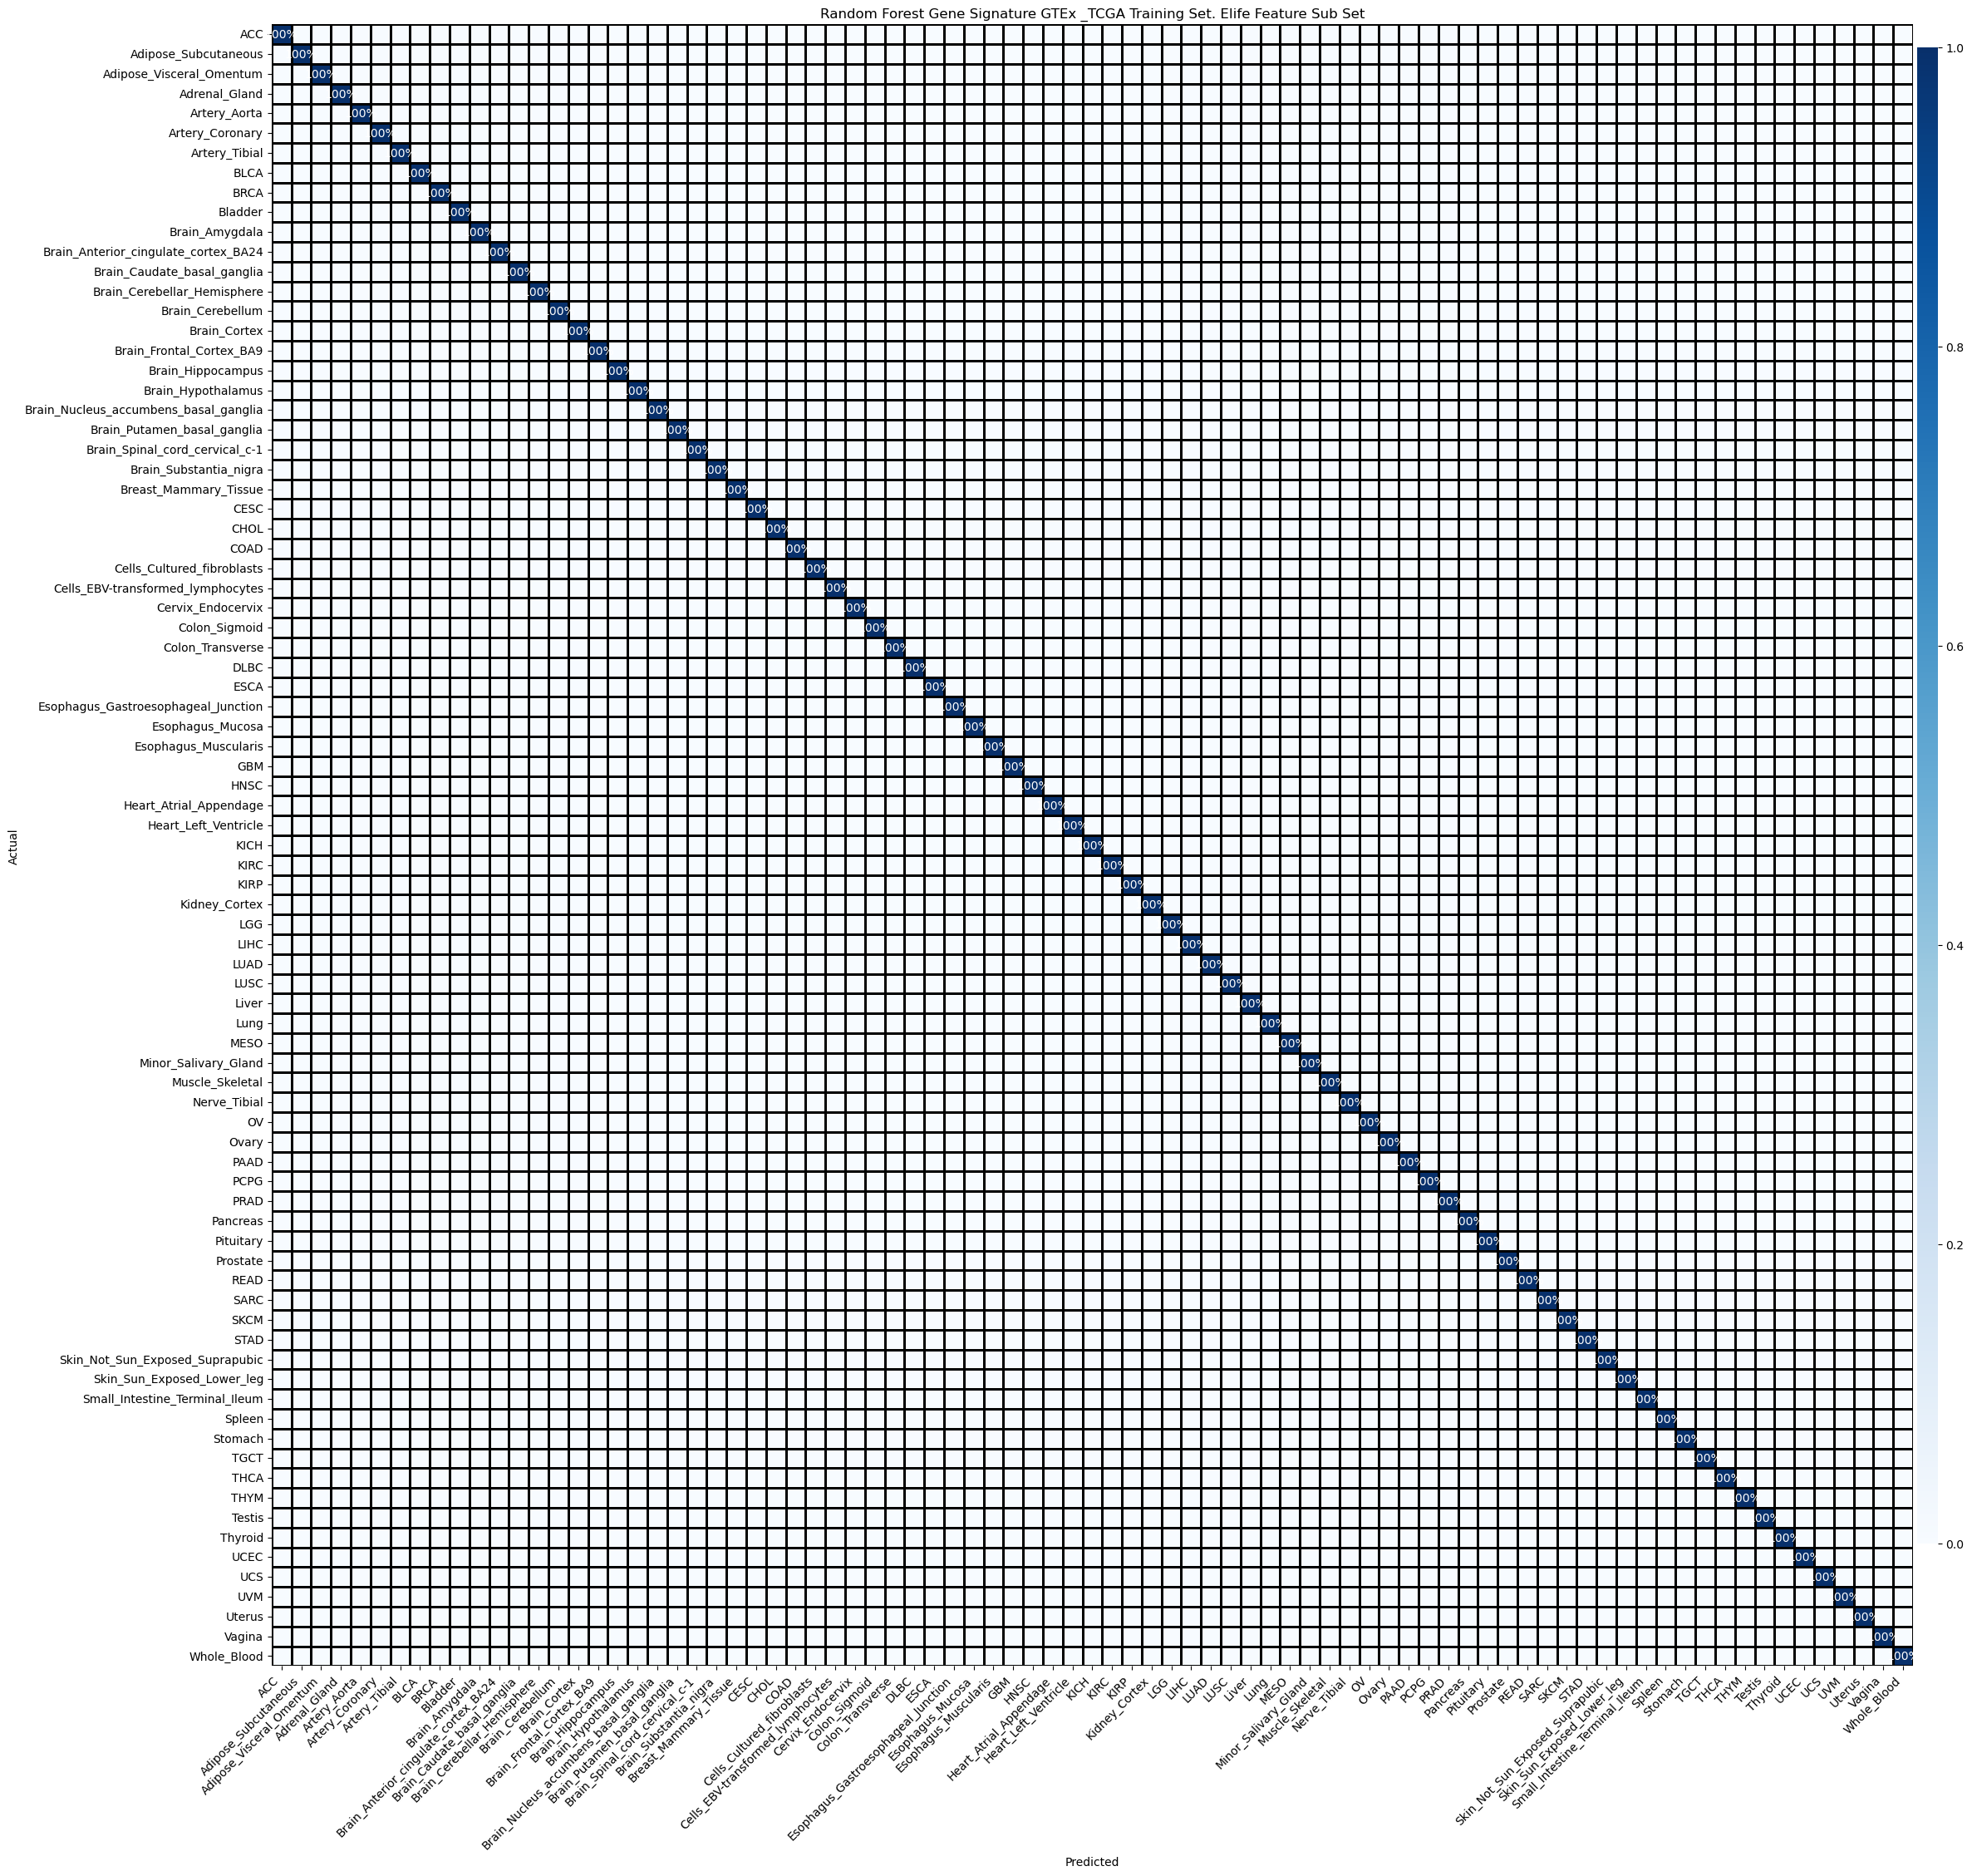

In [62]:
cm = confusion_matrix(yNP, yHatNP)
confusionData = calculateRowPercentages( cm )
labels =  labelList
annotations = createHeatMapAnnotations( confusionData )

if trainElifeFeatures :
    title="Random Forest Gene Signature GTEx _TCGA Training Set. Elife Feature Sub Set"
else:
    title="Random Forest Gene Signature GTEx _TCGA Training Set"
    
pageWidthInInches = 20
pageHeightInInches  = 20
plotConfusionMatrix( confusionData, labels, annotations, imgOut, title, pageWidthInInches, 
                        pageHeightInInches, displayCounts=False )